In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import contextily as cx
from MODE_top_level import RegionalModel
from syspy.spatial.spatial import agglomerative_clustering
from quetzal.engine import engine
from syspy.skims import skims

c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-28 13:45:33,127	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Create a regional model

Define the region and generate networks

Converted the coordinate reference system to EPSG:4326.


c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


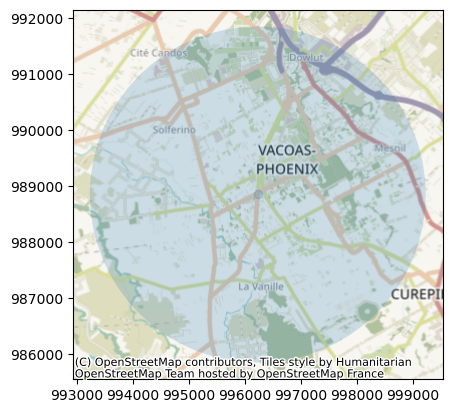

In [2]:
center = geometry.Point(57.4927352, -20.2988986)
region_name = 'Vacoas'
regio_df = gpd.GeoDataFrame(index=['center'], geometry=[center], crs=4326).to_crs('EPSG:3337')
regio_df.loc['city'] = regio_df.buffer(3000).loc['center']
polygon = regio_df.loc['city', 'geometry']
buffer = 5000
# Init a regional model with quetzal properties
model = RegionalModel(polygon=polygon, buffer_size=buffer, epsg=3337, coordinates_unit='meter')
# Save the geometry
regio_df.to_file('../model/'+region_name+'/region_geometries.geojson', driver='GeoJSON')
# Plot
plot = regio_df.plot(alpha=.2)
cx.add_basemap(ax=plot, crs='EPSG:3337', zoom=13)

# Road network

Driving, cycling, and walking

In [3]:
# Generate road networks
model.generate_street_networks(
    path_to_graphml='../input/OSM_region_'+region_name+'.graphml',
    car=True, bike=True, walk=True, walkable=['designated', 'on_street', 'main_road', 'unknown'])
#model.load_networks_road('../model/'+region_name+'/networks_road/')

try loading from file
graph loaded from file
fix maximum speed from OSM data
fix lane count from OSM data
calculate road capacity
build road network
simplifing car network
fix maximum speed from OSM data
fix lane count from OSM data
calculate road capacity
build cycling network
classify quality of cycling paths
simplifing cycling network
Calculate time on link
classify walking paths
simplifing walking network
Calculate time on link


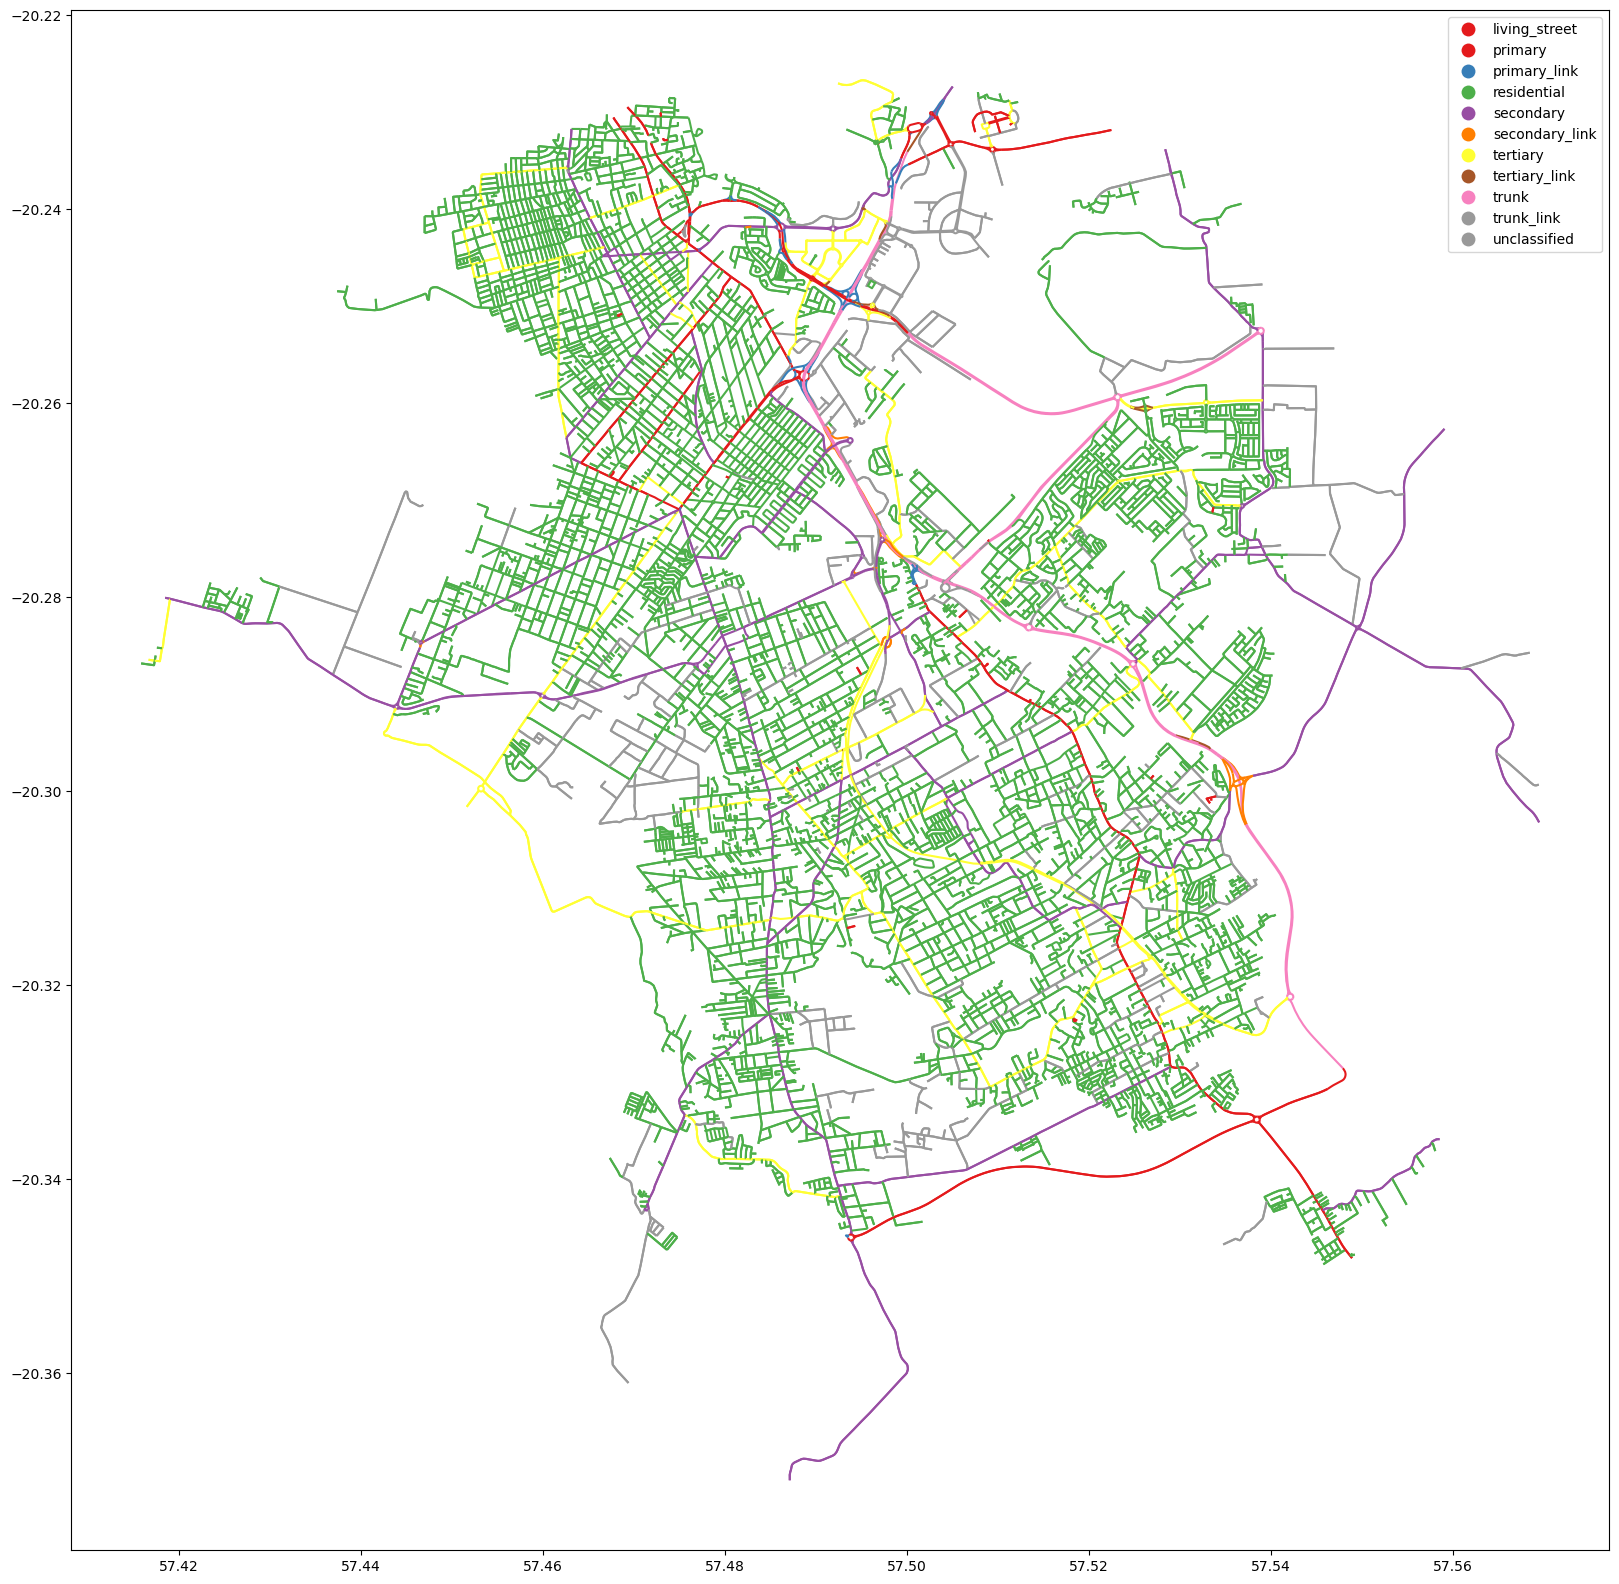

In [4]:
model.auto_links.plot(column = 'highway', cmap = 'Set1', legend = True, figsize = (20,20))#,
#                      ax=regio_df.to_crs(crs=4326).loc[[0]].plot(alpha=0.2, figsize = (20,20)))
#plt.xlim(6.0,6.8)
#plt.ylim(50.6,51.1)
plt.savefig('../output/'+region_name+'/network_car.png', dpi=400)

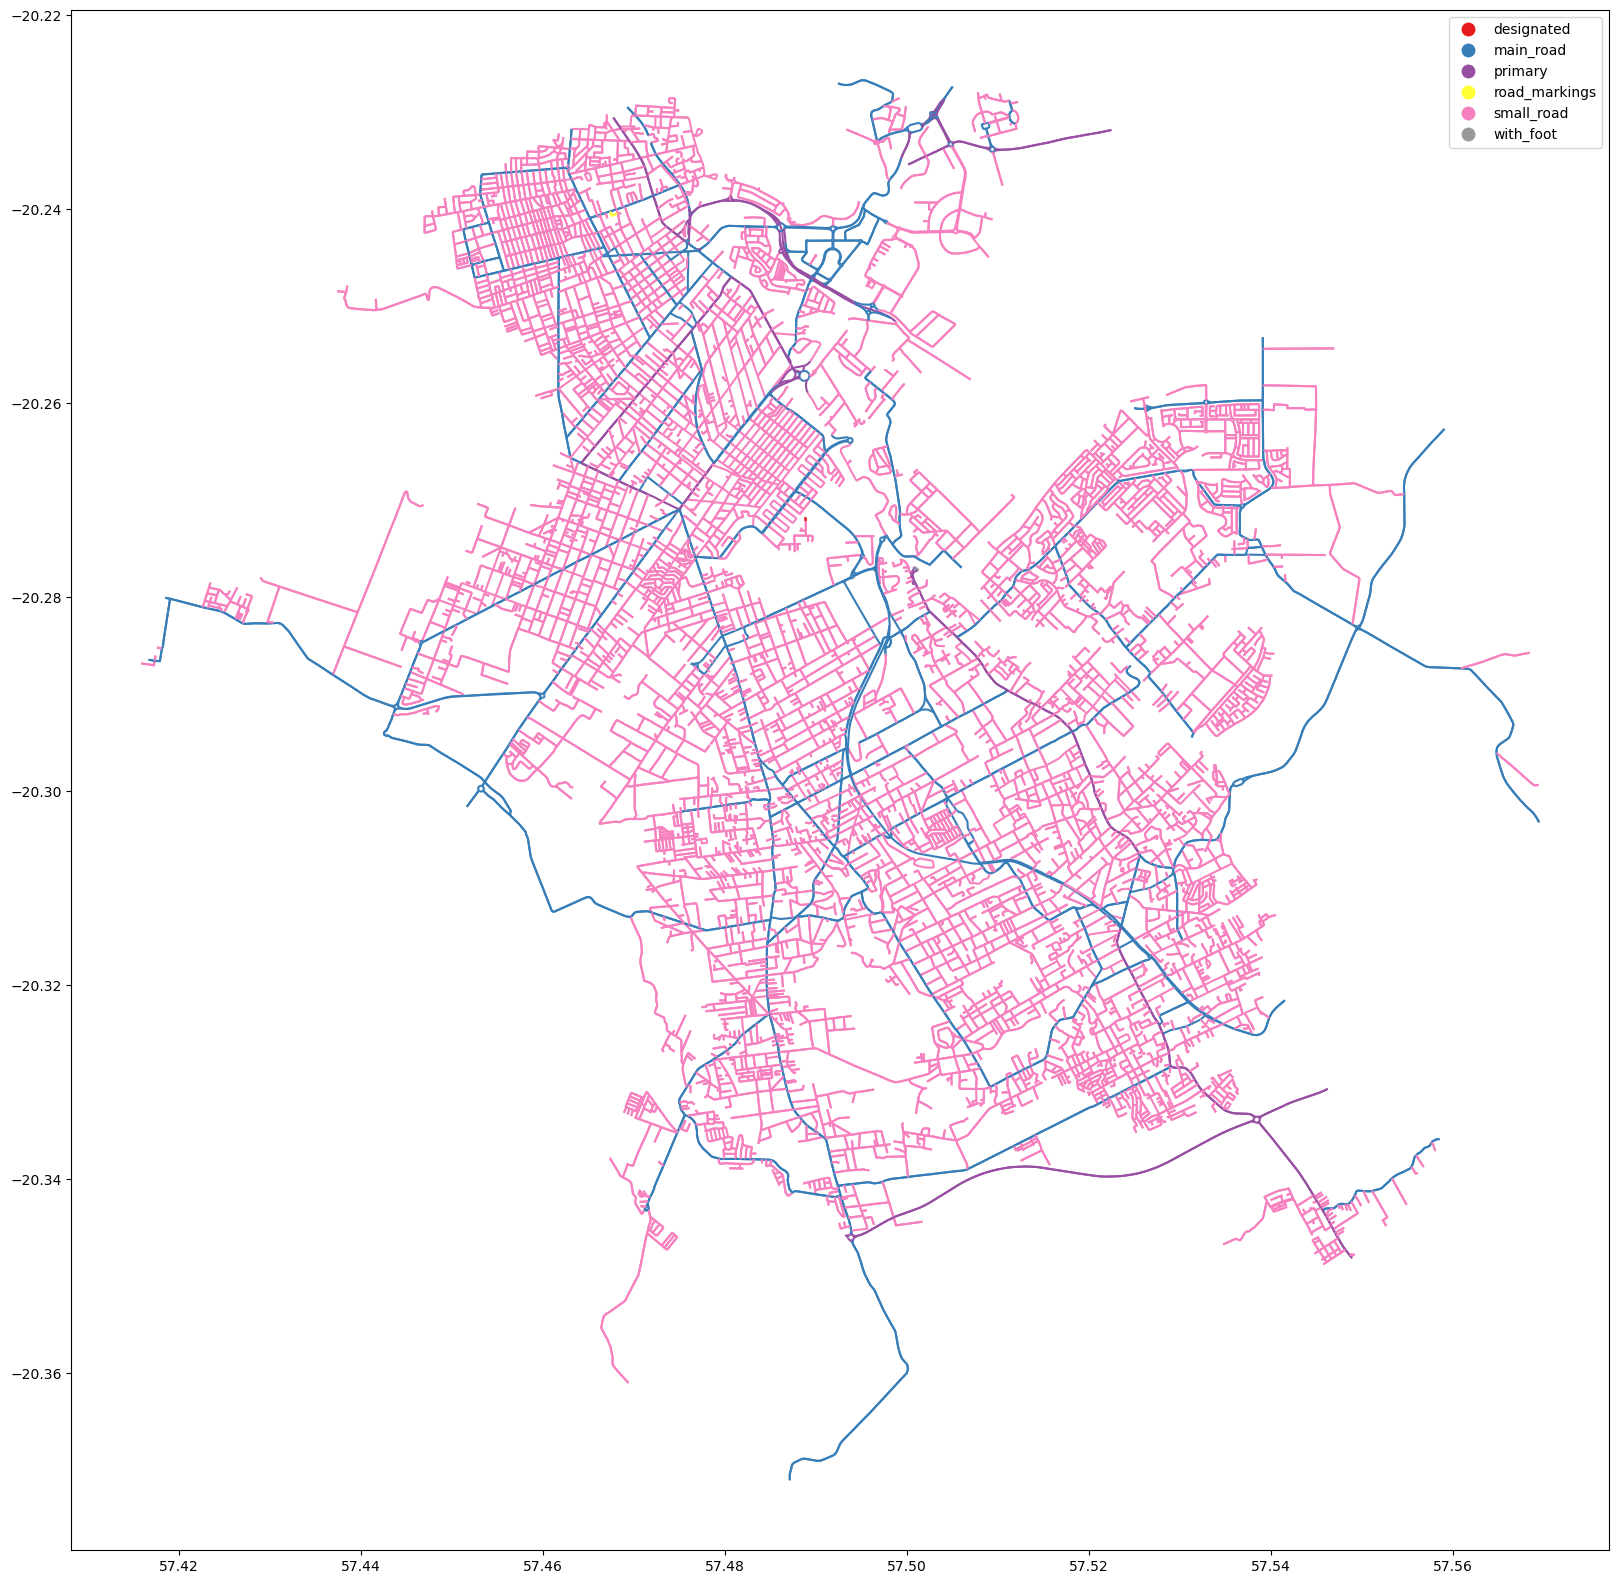

In [5]:
model.cycle_links.plot(column = 'way_quality', cmap = 'Set1', legend = True, figsize = (20,20))#,
#                      ax=regio_df.to_crs(crs=4326).loc[[0]].plot(alpha=0.2, figsize = (20,20)))
#plt.xlim(6.0,6.8)
#plt.ylim(50.6,51.1)
plt.savefig('../output/'+region_name+'/network_bicycle.png', dpi=400)

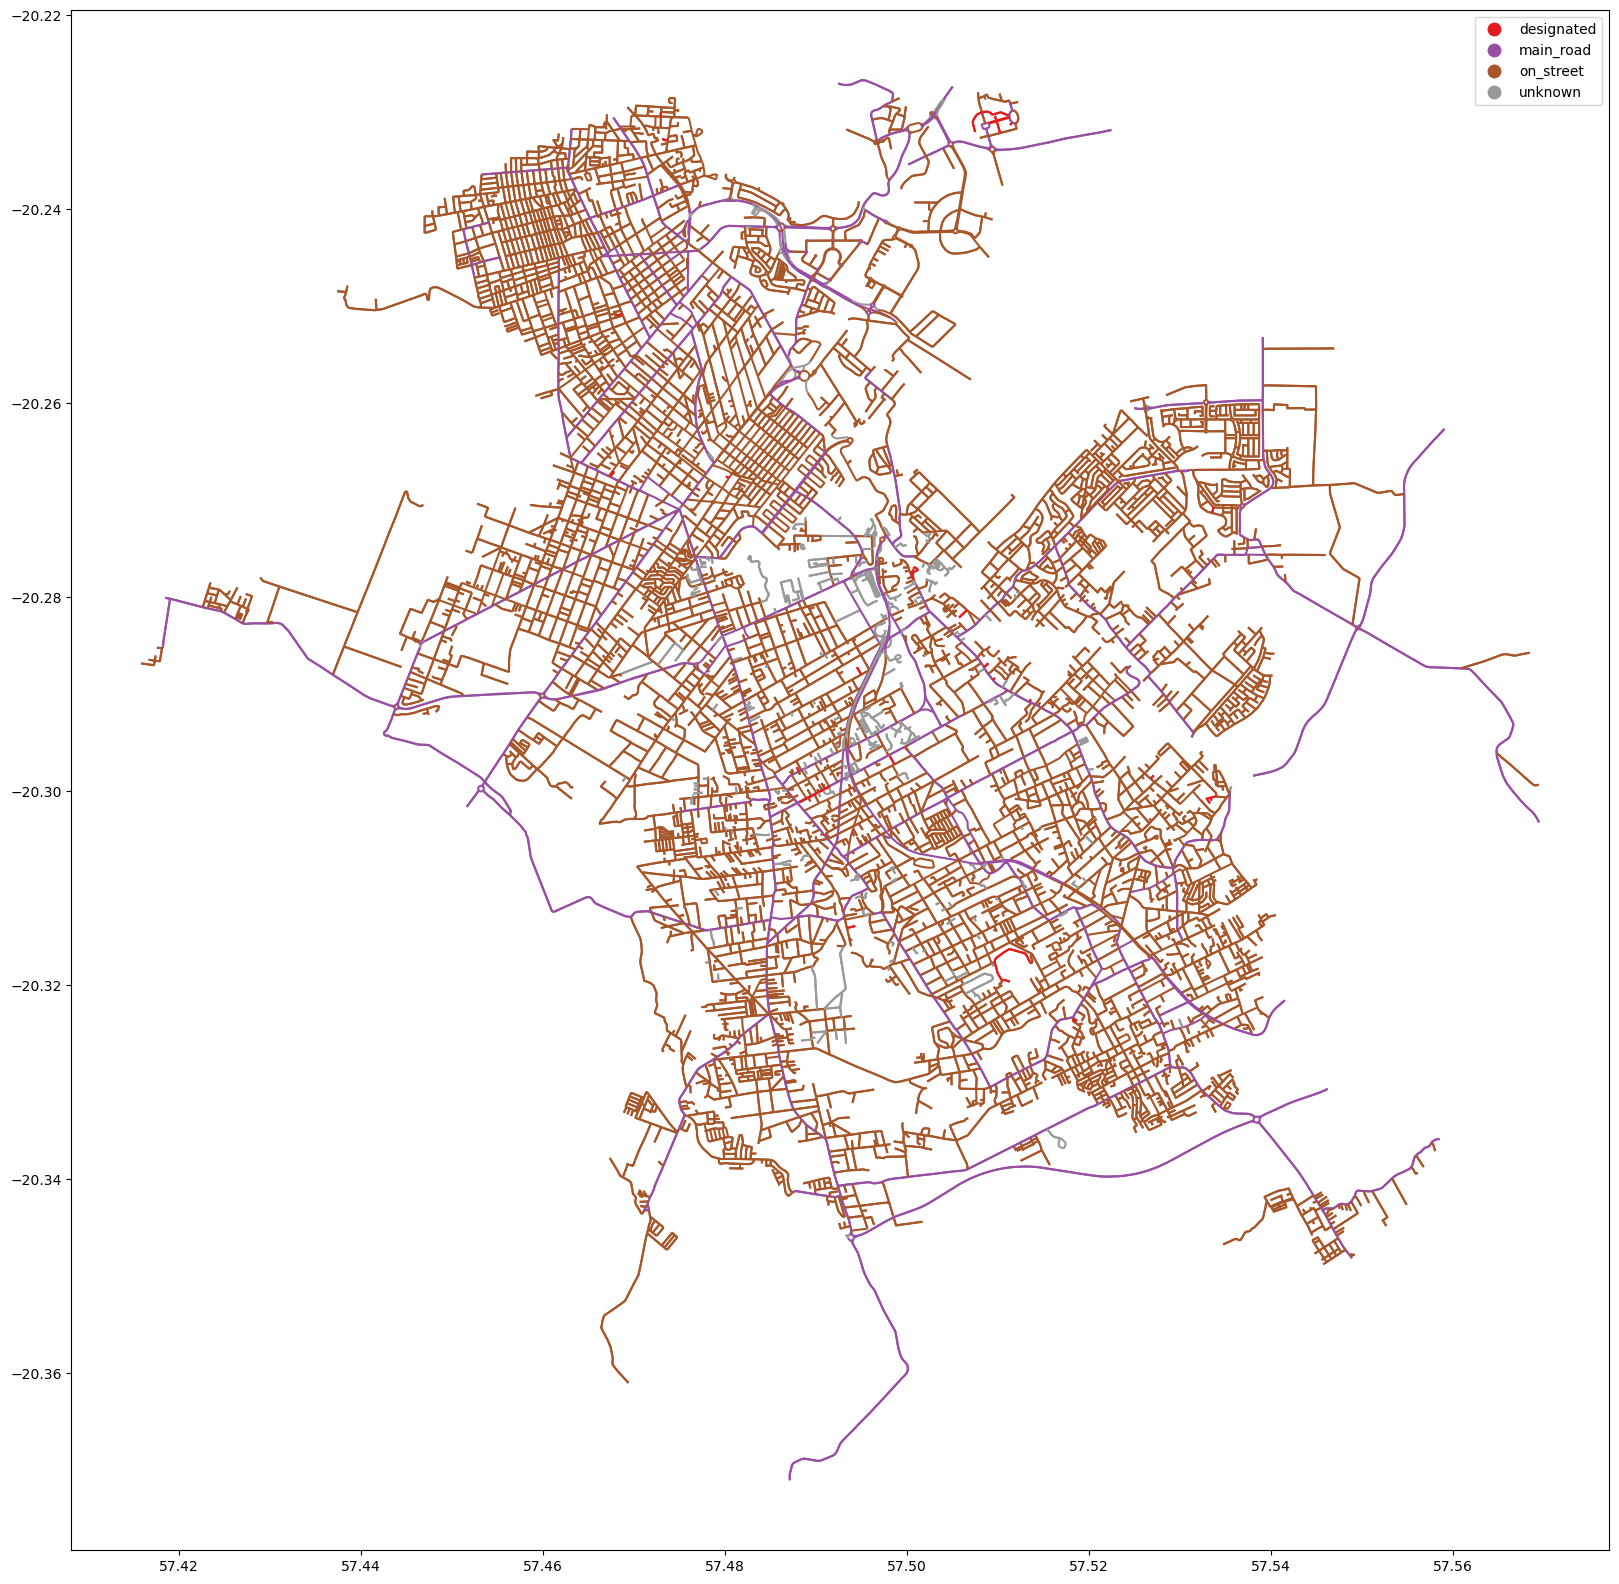

In [6]:
model.walk_links.plot(column = 'footway_class', cmap = 'Set1', legend = True, figsize = (20,20))#,
#                      ax=regio_df.to_crs(crs=4326).loc[[0]].plot(alpha=0.2, figsize = (20,20)))
#plt.xlim(6.0,6.8)
#plt.ylim(50.6,51.1)
plt.savefig('../output/'+region_name+'/network_walk.png', dpi=400)

In [7]:
model.save_networks_road('../model/'+region_name+'/networks_road/')

# Public transit network

Generate pt_links and pt_nodes, also relevant for P&R pathfinding.

In [8]:
# Construct bus network from Mauritius Excel data
def parse_route_from_sheet(file, sheet):
    # Parse
    forth = file.parse(sheet, usecols=[0,1,2], names=['name', 'coords', 'time'], skiprows=13)
    back = file.parse(sheet, usecols=[3,4,5], names=['name', 'coords', 'time'], skiprows=13)
    forth['trip_id'] = str(sheet) + '_forth'
    back['trip_id'] = str(sheet) + '_back'
    forth['name'] = forth['trip_id'] + '_' + forth['name'].astype(str)
    back['name'] = back['trip_id'] + '_' + back['name'].astype(str)

    # nodes
    df = pd.concat([forth, back])
    try:
        x = df['coords'].apply(lambda s: s.split(', ')[1])
        x = [val if val[-1]!=')' else val[:-1] for val in x]
        y = df['coords'].apply(lambda s: s.split(', ')[0])
        y = [val if val[0]!='(' else val[1:] for val in y]
        y = [val if val[0]=='-' else '-'+val for val in y]
        df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x,y), crs='EPSG:4326')
    except:
        print(sheet + ': network generation failed due to corrupted coordinates')
        return gpd.GeoDataFrame(), gpd.GeoDataFrame()
    nodes = df[['geometry', 'name']].set_index('name')

    # links
    try:
        headway = file.parse(sheet, skiprows=6, nrows=1, header=None)
        headway = headway.loc[0]
        headway = headway.loc[headway.notna()]
        headway = list(headway.loc[headway.apply(lambda val: not isinstance(val, str))])[0]
    except:
        print(sheet + ': no headway added in row 7. Assume 60 minutes')
        headway = 60
    forth['headway'] = headway
    back['headway'] = headway
    forth['link_sequence'] = [i for i in range(1,len(forth)+1)]
    back['link_sequence'] = [i for i in range(1,len(back)+1)]
    forth['a'] = forth['name']
    forth['b'] = list(forth['name'])[1:] + ['None']
    back['a'] = back['name']
    back['b'] = list(back['name'])[1:] + ['None']
    # add times
    forth = forth.loc[forth['time'].apply(lambda x: pd.api.types.is_number(x))]
    back = back.loc[back['time'].apply(lambda x: pd.api.types.is_number(x))]
    for df in [forth, back]:
        try:
            if pd.isna(df.iloc[0,2]): df.iloc[0,2] = 0
            df['time'] = df['time'].astype(int)
        except pd.errors.IntCastingNaNError:
            try:
                # Search for first and last time and interpolate linearly in between
                df = df.loc[:df['time'].last_valid_index()]
                if len(df) > 1:
                    df.loc[:,'time'] = df['time'].interpolate(method='linear')
                    df.loc[:,'time'] = df['time'].astype(int)
                    print(sheet + ': interpolated missing times linearly')
                else:
                    print(sheet + ': skipped due to missing times')
                    return gpd.GeoDataFrame(), gpd.GeoDataFrame()
            except:
                print(sheet + ': network generation failed due to corrupted times')
                return gpd.GeoDataFrame(), gpd.GeoDataFrame()
        finally:
            df.loc[:, 'time'] = [arr - dep for arr, dep in zip(df['time'].iloc[1:], df['time'].iloc[:-1])] + [0]
    # construct dataframe
    cols = ['a', 'b', 'time', 'trip_id', 'link_sequence', 'headway']
    links = pd.concat([forth[cols].iloc[:-1], back[cols].iloc[:-1]])
    links['dep_wd'] = 'generic' # weekday
    links['time'] *= 60 # convert to seconds
    links['arr_sec'] = links['time']
    links['dep_sec'] = links['time']
    # Add geometry
    try:
        lines = [geometry.LineString([nodes['geometry'][a], nodes['geometry'][b]]) for a,b in zip(links['a'], links['b'])]
        links = gpd.GeoDataFrame(links, geometry=lines, crs='EPSG:4326')
        links['length'] = skims.distance_from_geometry(links['geometry']).astype(int)
    except:
        print(sheet + ': No idea why geometry generation in links failed')
        return gpd.GeoDataFrame(), gpd.GeoDataFrame()
    
    return nodes, links

Sheet3: network generation failed due to corrupted coordinates
Sheet6: skipped due to missing times
Sheet7: interpolated missing times linearly
Sheet7: interpolated missing times linearly
Sheet8: interpolated missing times linearly
Sheet8: interpolated missing times linearly
Sheet9: interpolated missing times linearly
Sheet9: interpolated missing times linearly
Sheet10: interpolated missing times linearly
Sheet10: interpolated missing times linearly
Sheet11: interpolated missing times linearly
Sheet11: interpolated missing times linearly
Sheet12: interpolated missing times linearly
Sheet12: skipped due to missing times
Sheet13: interpolated missing times linearly
Sheet13: interpolated missing times linearly
Sheet14: interpolated missing times linearly
Sheet14: interpolated missing times linearly
Sheet15: interpolated missing times linearly
Sheet15: interpolated missing times linearly
Sheet16: interpolated missing times linearly
Sheet16: interpolated missing times linearly
Sheet25: no h

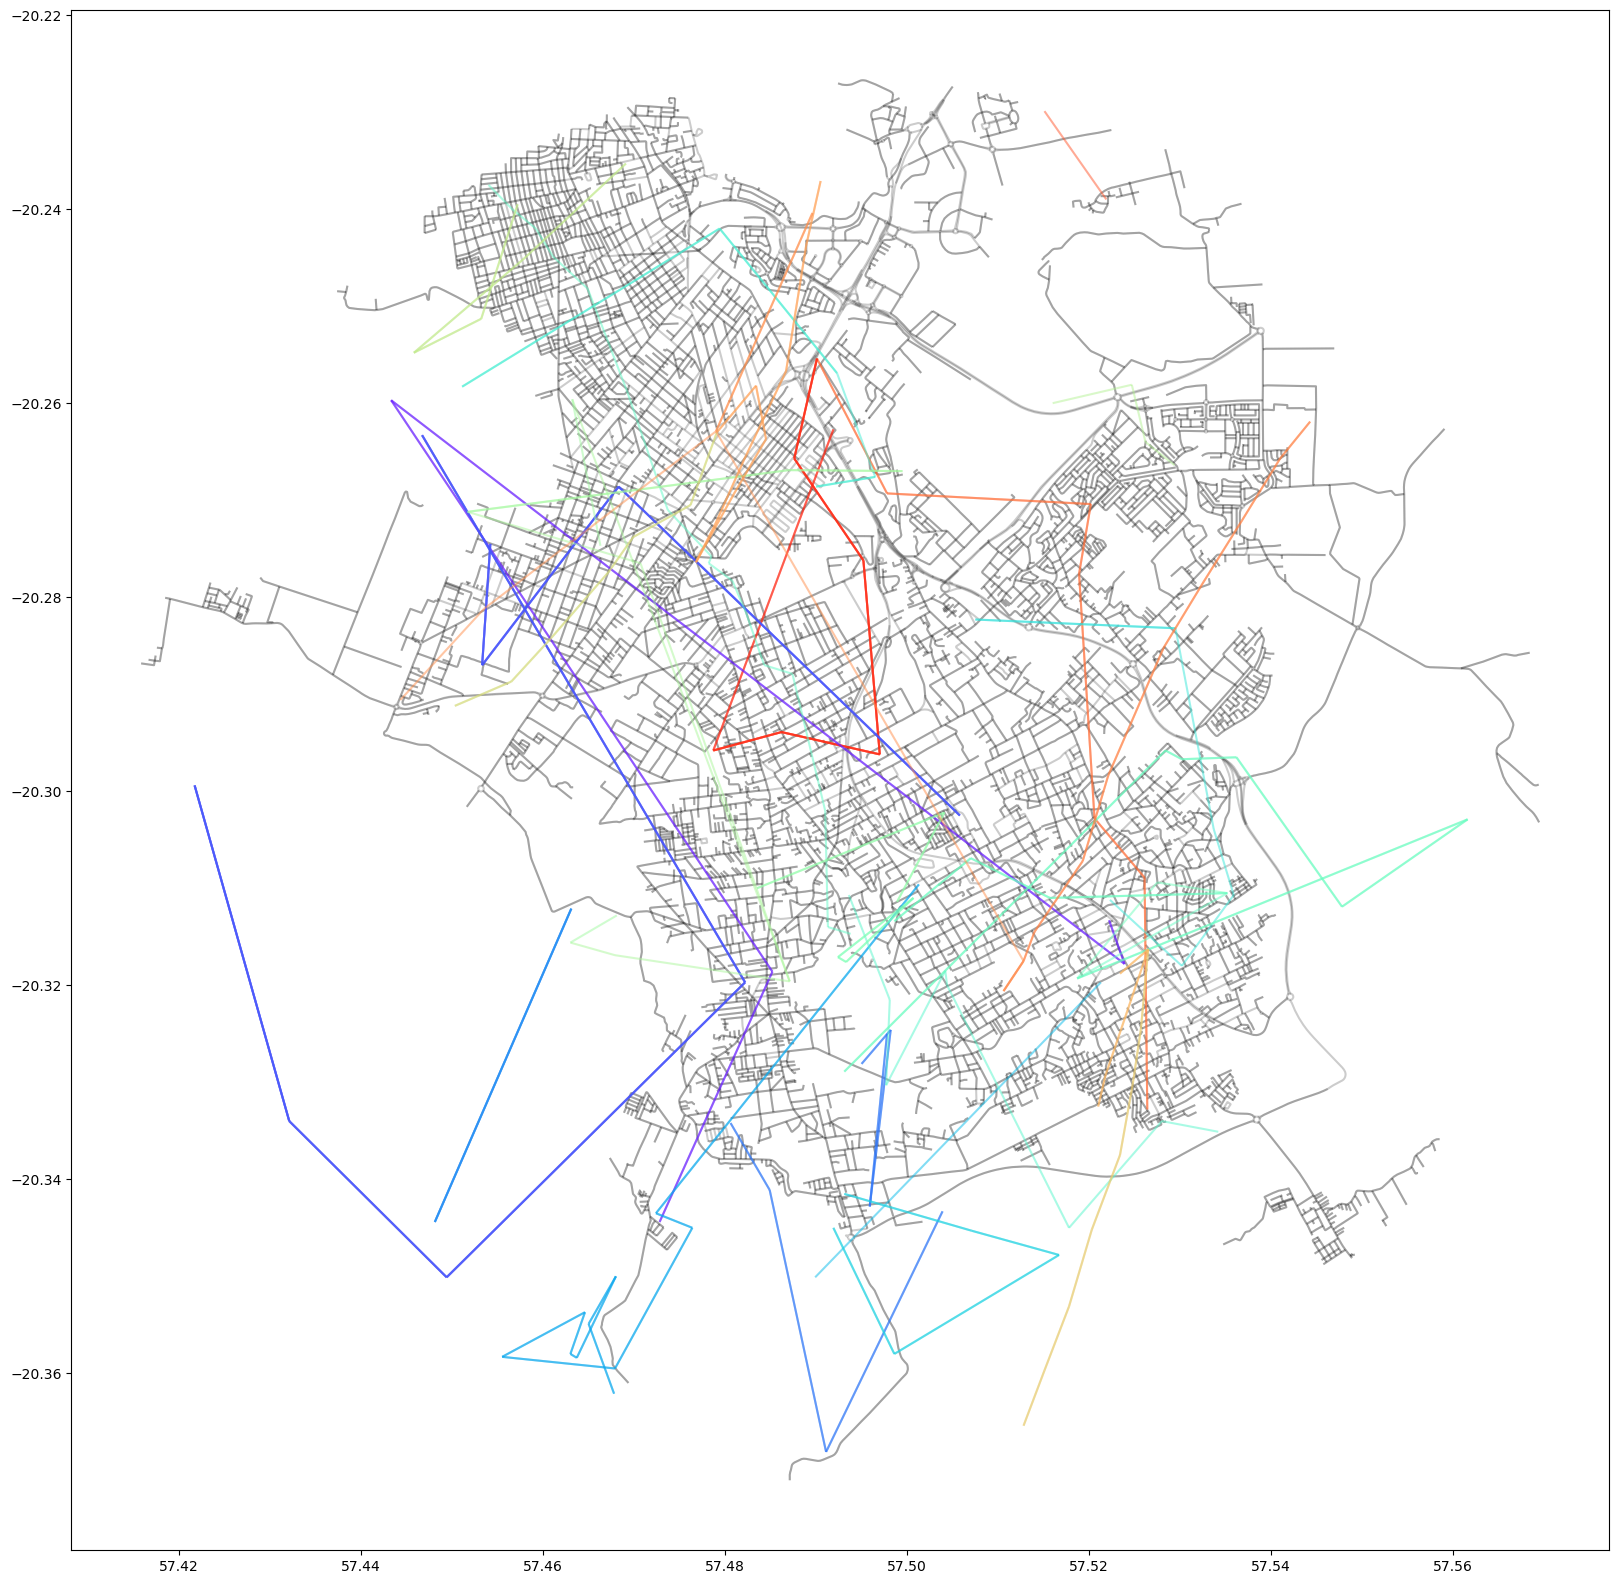

In [9]:
file = pd.ExcelFile('../input/public_transport/Mauritius/Bus Network1.2.1.xlsx')
nodes = []
links = []
for sheet in file.sheet_names:
    n,l = parse_route_from_sheet(file, sheet)
    nodes.append(n)
    links.append(l)
file.close()
model.pt_nodes = pd.concat(nodes)
model.pt_links = pd.concat(links).reset_index(drop=True)
model.pt_links.index = 'pt-links_' + model.pt_links.index.astype(str)
model.pt_links['time'] = model.pt_links['time'].clip(lower=60)
model.pt_links['route_type'] = 'bus'
# Restrict spatially
model.pt_nodes = model.pt_nodes.loc[model.pt_nodes['geometry'].apply(lambda g: model.total_area.contains(g))]
model.pt_links = model.pt_links.loc[(model.pt_links['a'].isin(model.pt_nodes.index))
                                    & (model.pt_links['b'].isin(model.pt_nodes.index))]
model.pt_links.plot(column='trip_id', cmap='rainbow', alpha=.5, ax=model.auto_links.plot(color='black', alpha=.2, figsize=(20,20)))
plt.savefig('../output/'+region_name+'/pt_network.png', dpi=400)

In [10]:
# Connect nodes with footpaths
footlinks = engine.ntlegs_from_centroids_and_nodes(
    model.pt_nodes, model.pt_nodes, n_neighbors=3, short_leg_speed=3)
footlinks = footlinks.loc[footlinks['distance']<300]
footlinks.index = footlinks.index.map(lambda x: f'link-pt_foot_{int(x):012d}')
footlinks.index = footlinks.index.rename('index')
model.pt_footpaths = gpd.GeoDataFrame(footlinks, geometry='geometry', crs=4326)
len(model.pt_footpaths)

2128

In [11]:
# Save PT networks
model.save_network_pt('../model/'+region_name+'/networks_pt/')

# POI data

exctract relevant Points of Interest data from OpenStreetMap

In [12]:
geodata_path = '../input/Mauritius_geodata_Geofabrik/'

c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_21140\4155441520.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  residential = residential.loc[residential['geometry'].area < area_thresh]


<Axes: >

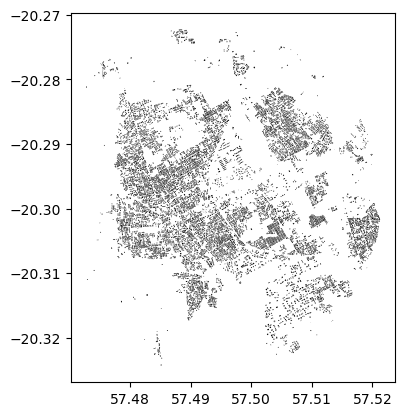

In [13]:
# Load buildings data
buildings = gpd.read_file(geodata_path + 'gis_osm_buildings_a_free_1.shp', crs=4326)
buildings['type'] = buildings['type'].fillna('house').astype(str).replace({'None': 'house'})
residential = buildings.loc[buildings['type'].isin(['house', 'residential'])]
residential = residential.loc[residential['geometry'].within(model.study_region_polygon)]
area_thresh = 5.140128484099244e-08 #residential['geometry'].area.mean() * 2
residential = residential.loc[residential['geometry'].area < area_thresh]
residential.plot(color='black')

In [14]:
area_thresh

5.140128484099244e-08

c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(
c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(
c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


<Axes: xlabel='fclass'>

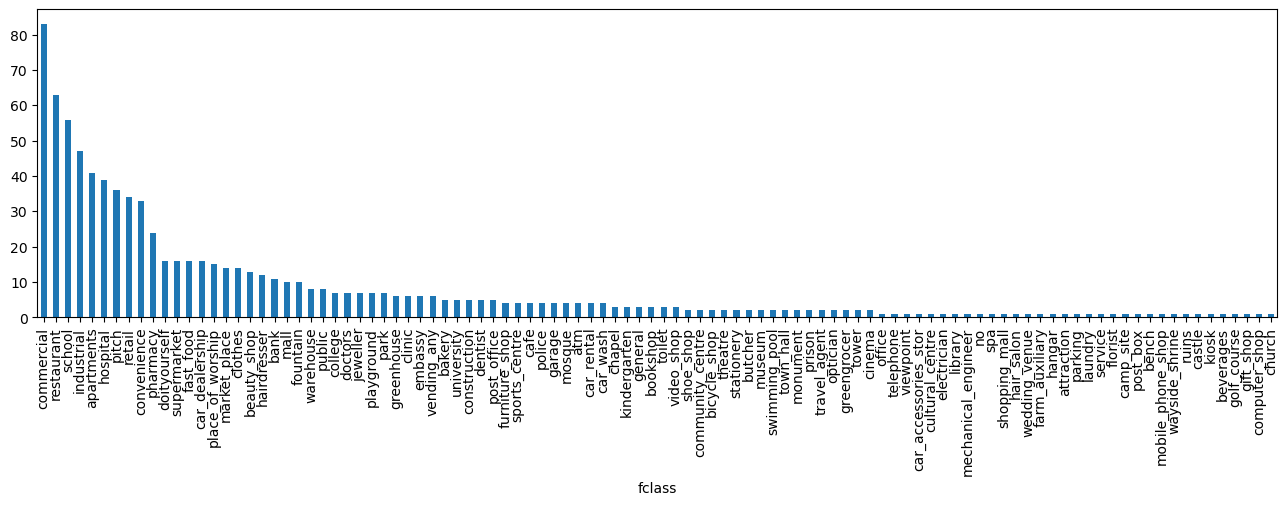

In [15]:
# Load POI data
pois = gpd.read_file(geodata_path + 'gis_osm_pois_free_1.shp', crs='EPSG:4326').to_crs('EPSG:3337')
pois_area = gpd.read_file(geodata_path + 'gis_osm_pois_a_free_1.shp', crs='EPSG:4326').to_crs('EPSG:3337')
pois_area['geometry'] = pois_area.centroid
pows = gpd.read_file(geodata_path + 'gis_osm_pofw_free_1.shp', crs='EPSG:4326').to_crs('EPSG:3337')
pows['fclass'] = 'place_of_worship'
poi_buildings = buildings.loc[~(buildings['type'].isin(['house', 'residential', 'roof'])) & (buildings['type'].notna())
                              ].drop('fclass', axis=1).rename(columns={'type': 'fclass'}).to_crs('EPSG:3337')
poi_buildings['geometry'] = poi_buildings.centroid
pois = pd.concat([pois.to_crs('EPSG:4326'),
                  pois_area.to_crs('EPSG:4326'),
                  pows.to_crs('EPSG:4326'),
                  poi_buildings.to_crs('EPSG:4326')])
pois = pois.loc[pois['geometry'].within(model.study_region_polygon)]
pois.fclass.value_counts().plot.bar(figsize=(16,4))

In [16]:
# Save
pois.reset_index(drop=True).to_file('../model/'+region_name+'/pois.geojson', driver='GeoJSON')
residential.reset_index(drop=True).to_file('../model/'+region_name+'/residential.geojson', driver='GeoJSON')

In [17]:
# Load
pois = gpd.read_file('../model/'+region_name+'/pois.geojson', crs='EPSG:4326')
residential = gpd.read_file('../model/'+region_name+'/residential.geojson', crs='EPSG:4326')

c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(
c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


In [18]:
# Assign POIs to trip purposes
purpose_pois = {
    '1': list(pois['fclass'].unique()), # commuting
    '2': ['college', 'school', 'university'], # education
    '3': ['playground', 'school', 'clinic', 'doctors', 'kindergarten'], # accompaniment
    '41': ['restaurant', 'fast_food', 'cafe', 'pub', 'bar'], # social, cultural
    '42': ['museum', 'cinema', 'theatre', 'community_centre', 'library', 'place_of_worship', 'church', 'chapel', 'mosque', 'artwork', 'town_hall', 'arts_centre'], # social, cultural
    '51': ['convenience', 'supermarket', 'bakery', 'market_place', 'butcher', 'mall'], # errands
    '52': ['bank', 'pharmacy', 'doityourself', 'stationery', 'government', 'post_office', 'vending_any'], # errands
    '6': ['clinic', 'doctors'], # healthcare
    '7': ['attraction', 'park', 'memorial', 'fountain', 'viewpoint', 'monument', 'pitch', 'picnic_site', 'swimming_pool', 'sports_centre'], # recreational, outdoors
}

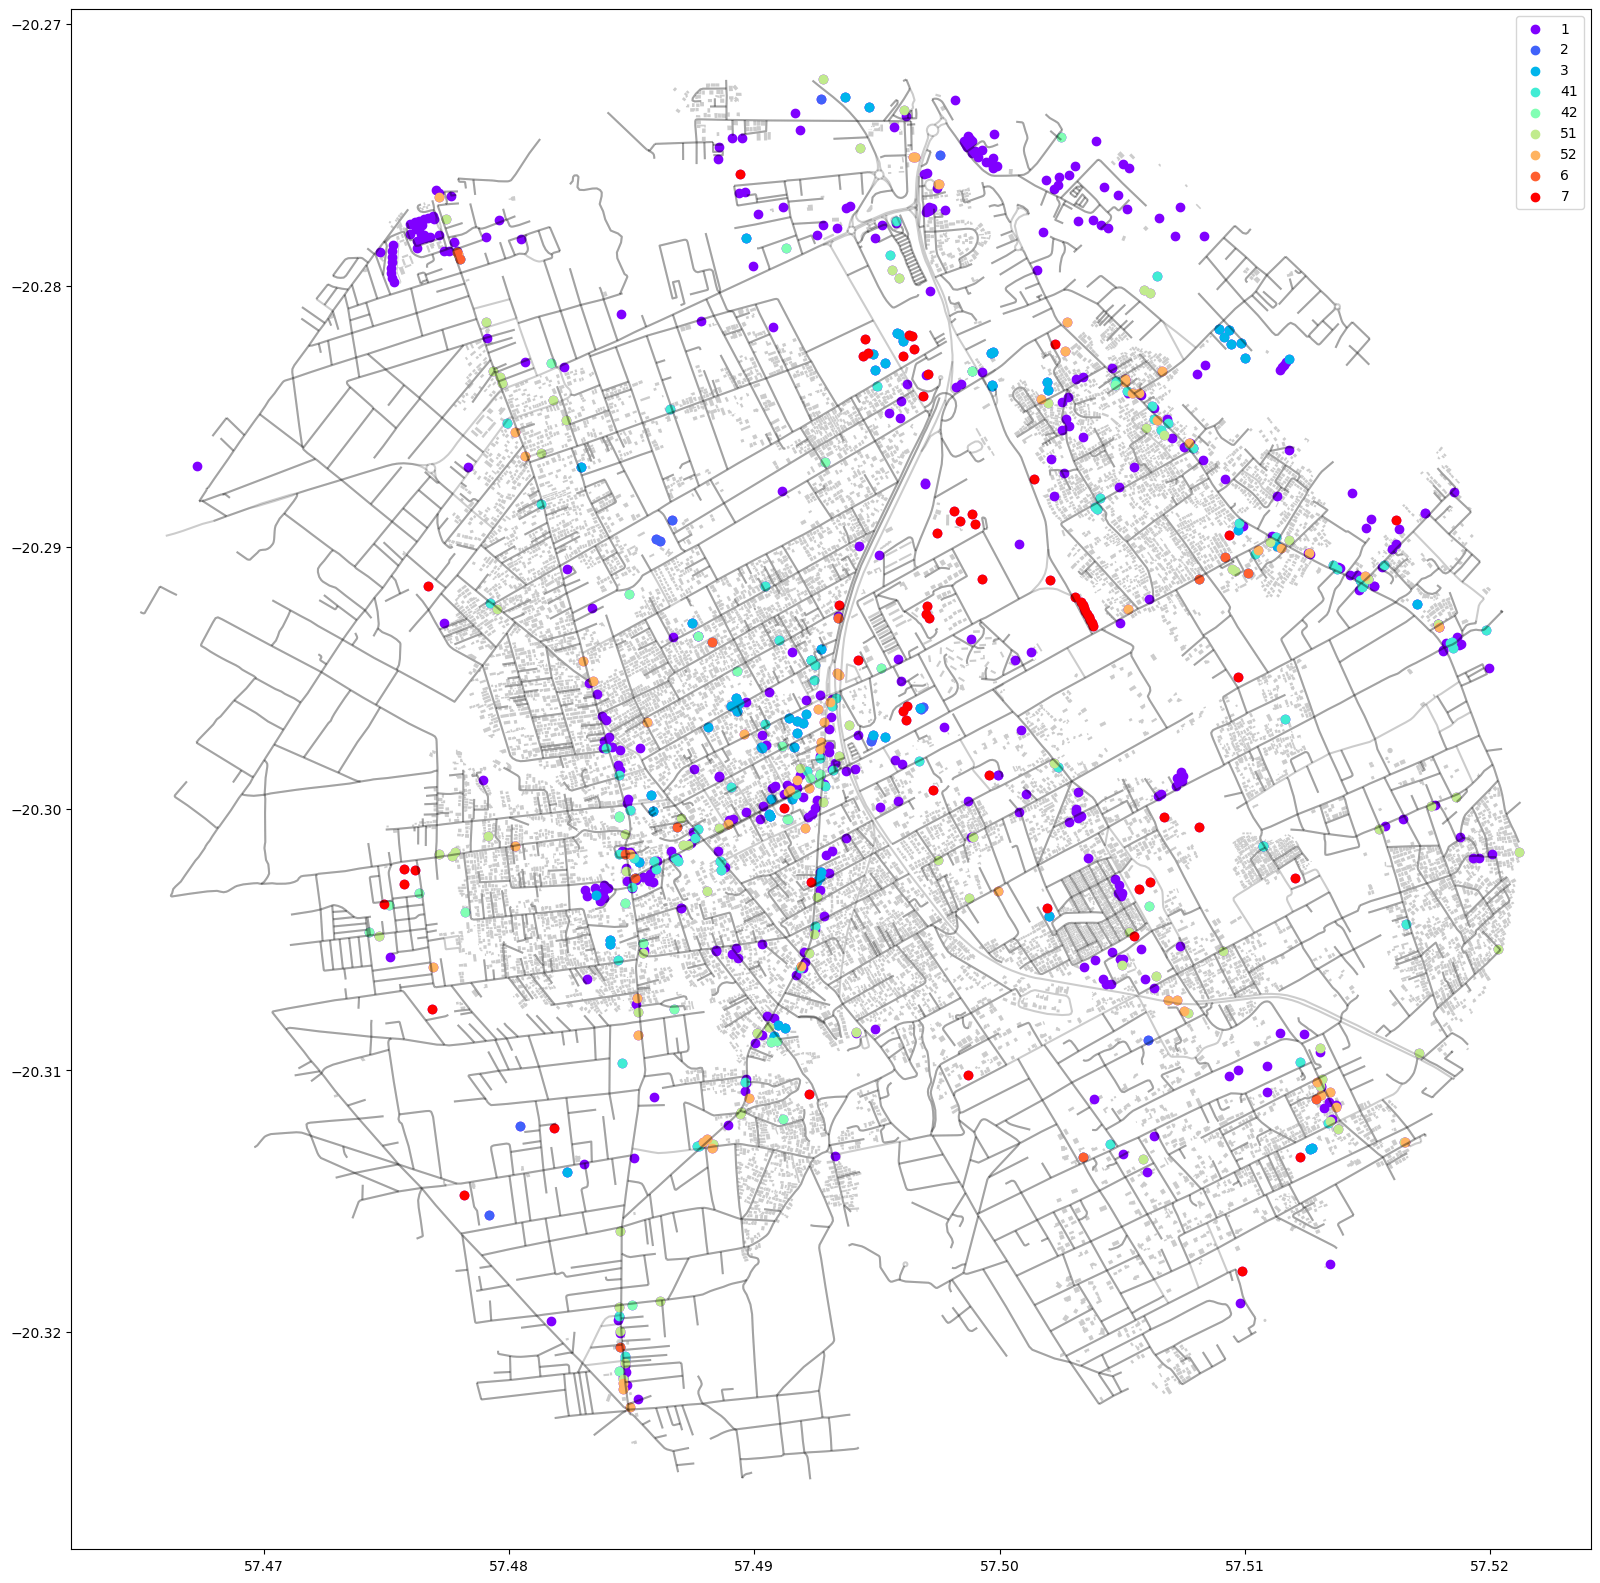

In [19]:

plot = model.walk_links.loc[model.walk_links['geometry'].within(model.study_region_polygon)
                            ].plot(color='black', alpha=0.2, ax=residential.plot(color='black', alpha=.2, figsize=(20,20)))
colors = iter(cm.rainbow(np.linspace(0, 1, len(purpose_pois))))
for purpose, values in purpose_pois.items():
    pois[purpose] = pois['fclass'].isin(values)
    pois.loc[pois[purpose]].plot(color=next(colors), label=str(purpose), ax=plot)
plot.legend()
plt.savefig('../output/'+region_name+'/pois.png', dpi=400)

In [20]:
len(pois)

838

# Pathfinding

cars, PT, cycling, walking

In [21]:
# generate an origin-destination table
# from residentials and POIs and every combination between them
pois['activity'] = ''
for p in purpose_pois.keys():
     pois.loc[pois[p], 'activity'] = p
pois_ = pois[['osm_id', 'geometry', 'activity']].rename(columns={'osm_id':'origin_id', 'geometry':'origin'}).drop_duplicates().sample(500)
# Cluster the origin destinations
o = residential.copy().to_crs(epsg=3337)
o['geometry'] = o.centroid
o['cluster'] = agglomerative_clustering(o, distance_threshold=200)
o = o.groupby('cluster').first()
o = o.set_crs(epsg=3337).to_crs(epsg=4326).reset_index()
o = o[['cluster', 'geometry']].rename(columns={'cluster':'origin_id', 'geometry':'origin'}).drop_duplicates().sample(100)
# Cross-merge tables
o_poi = pd.merge(o, pois_.rename(columns={'origin_id':'destination_id', 'origin':'destination'}), how='cross')
poi_poi = pd.merge(pois_, pois_.rename(columns={'origin_id':'destination_id', 'origin':'destination'}).drop('activity', axis=1), how='cross')
poi_o = pd.merge(pois_, o.rename(columns={'origin_id':'destination_id', 'origin':'destination'}), how='cross')
od_df = pd.concat([o_poi, poi_poi, poi_o]).drop_duplicates(subset=['origin_id', 'destination_id']).reset_index(drop=True)
od_df = od_df.loc[od_df['origin_id']!=od_df['destination_id']]
len(od_df)

344720

In [22]:
model.pathfinding_auto(od_df)
len(model.auto_los)

self.volumes does not exist. od generated with self.zones


344720

In [23]:
model.pathfinding_cycling(od_df)
len(model.cycle_los)

self.volumes does not exist. od generated with self.zones


344720

In [24]:
model.pathfinding_walk(od_df)
len(model.walk_los)

self.volumes does not exist. od generated with self.zones


344720

In [25]:
model.pathfinding_public_transport(od_df, weekday='generic')
model.pt_los = model.pt_los[~model.pt_los['all_walk']]
model.pt_los = model.pt_los[model.pt_los['ntransfers']<3]
len(model.pt_los)

path_analysis: 100%|██████████| 344720/344720 [00:10<00:00, 33695.00it/s]


201587

# Save

In [26]:
# Save
model.volumes = od_df
model.to_zippedpickles('../model/'+region_name+'/los', only_attributes=[
    'auto_los', 'cycle_los', 'walk_los', 'pt_los', 'volumes'])

volumes: 100%|██████████| 35/35 [01:24<00:00,  2.43s/it]  
